Load necessary libraries.

In [1]:
### Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

### ML packages
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering #Hierarchial Clustering
from sklearn.mixture import GaussianMixture
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from collections import defaultdict

### Msc
import warnings

### OOP
from cluster_evaluator import ClusterEvaluator

Load dataset.

In [2]:
df = pd.read_csv('00_authors.csv').rename(columns = {'Unnamed: 0': 'Author'}).drop(columns = 'BookID')
X = df.copy().drop(['Author'], axis=1)
X = X.to_numpy() # change pd.DataFrame to np.ndarray
authors = df['Author'].values  # n_samples-length array

We can also assign a hyperparameter $K=4$.  This represents the number of clusters (which we already know; there are 4 authors). Later on we will be hyperparameter tuning for some $K$ based on stability!

In [3]:
K_ = 4

Let us also define a dictionary to store our results.

In [4]:
accuracy_dict = {}

# Clustering Methods

## Kmeans++

In [5]:
kmeans = KMeans(n_clusters=K_, init='k-means++', n_init=10, max_iter=300) # K-means++ initialization 
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
centers_pp = kmeans.cluster_centers_

accuracy, mapping = ClusterEvaluator(y_kmeans,df['Author'].values).accuracy
print(f'The mapping based on mode = {mapping}')
print(f'The accuracy of Kmeans++ = {accuracy}')
accuracy_dict['kmeans++'] = accuracy

The mapping based on mode = {0: 'Shakespeare', 1: 'London', 2: 'Austen', 3: 'London'}
The accuracy of Kmeans++ = 0.9084423305588585


## Gaussian Mixture Models

In [6]:
gmm = GaussianMixture(n_components=K_)
gmm.fit(X)
y_gmm = gmm.predict(X)

accuracy, mapping = ClusterEvaluator(y_gmm,df['Author'].values).accuracy
print(f'The mapping based on mode = {mapping}')
print(f'The accuracy of Kmeans++ = {accuracy}')
accuracy_dict['gmm'] = accuracy

The mapping based on mode = {0: 'Austen', 1: 'London', 2: 'London', 3: 'Shakespeare'}
The accuracy of Kmeans++ = 0.9167657550535078


## Spectral Clustering

Spectral clustering already had a dimensional reduction by design, i.e., spectral clustering is essentially spectral embedding followed by kmeans!  Therefore, we expect this 'raw' method to perform best compared to the other methods without any form of dimensionality reduction!

In [7]:
spectral = SpectralClustering(n_clusters=K_, affinity='nearest_neighbors')
y_spectral = spectral.fit_predict(X)

accuracy, mapping = ClusterEvaluator(y_spectral,df['Author'].values).accuracy
print(f'The mapping based on mode = {mapping}')
print(f'The accuracy of Kmeans++ = {accuracy}')
accuracy_dict['spectral clustering'] = accuracy

The mapping based on mode = {0: 'London', 1: 'Austen', 2: 'Shakespeare', 3: 'Milton'}
The accuracy of Kmeans++ = 0.9881093935790726


## Hierarchial Clustering

In [8]:
# Establish all possible combinations for linkage and metric!
methods = []
linkage_methods = ['ward', 'average', 'complete', 'single']
metrics = ['euclidean', 'manhattan', 'cosine']

for linkage in linkage_methods:
    for metric in metrics:
        if linkage == 'ward' and metric != 'euclidean':
            continue  # ward only supports euclidean
        methods.append((linkage, metric))

# Loop through all combinations and determine best accuracy!
hierarchical_accuracy_dict = {}
vals = df['Author'].values
for linkage, metric in methods:
    hierarchical = AgglomerativeClustering(n_clusters=K_, linkage=linkage, metric=metric)
    y_hierarchical = hierarchical.fit_predict(X)  # Fit and predict in one step
    accuracy, mapping = ClusterEvaluator(y_hierarchical,vals).accuracy # Use OOP code
    # print(f'The mapping based on mode = {mapping}')
    # print(f'The accuracy hierarchial clustering with {linkage} and {metric} = {accuracy}')
    hierarchical_accuracy_dict[f'{linkage}-{metric}'] = accuracy

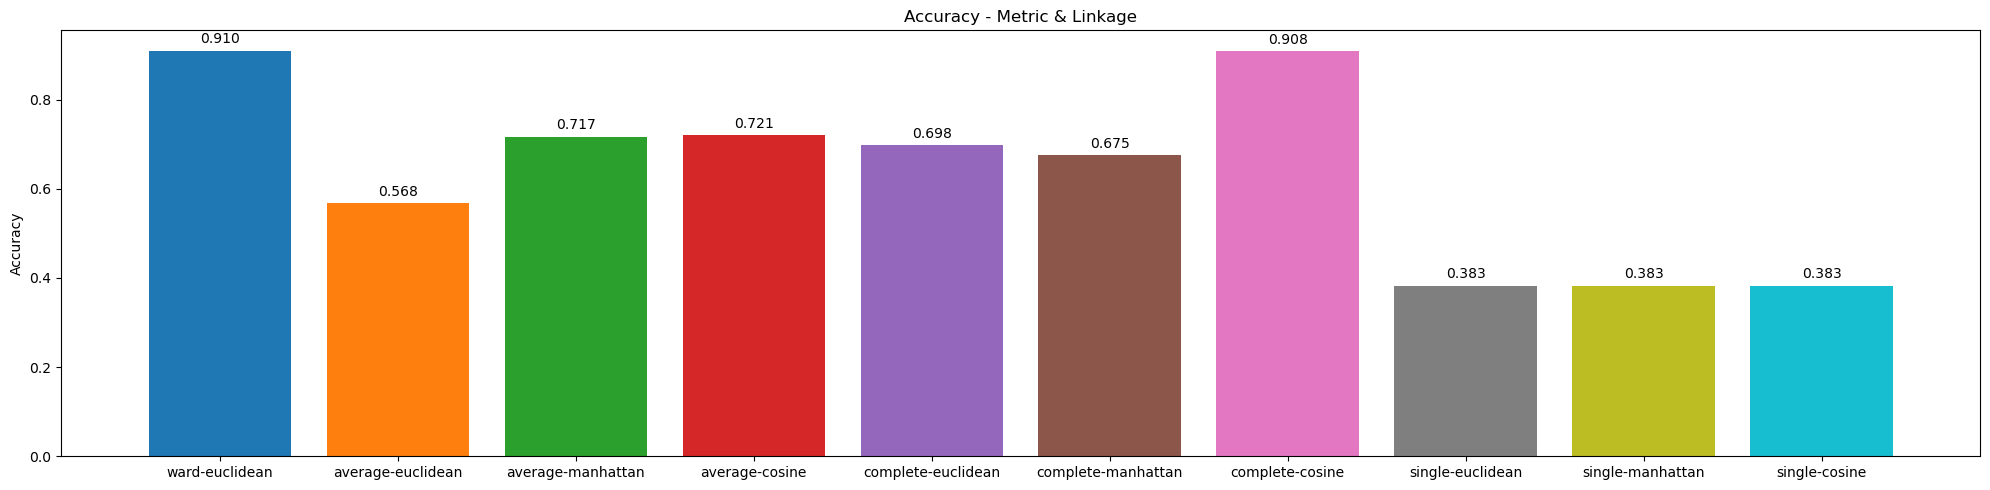

In [9]:
keys = list(hierarchical_accuracy_dict.keys())
vals = list(hierarchical_accuracy_dict.values())
colors = plt.colormaps.get_cmap('tab10').colors

fig, ax = plt.subplots(figsize=(20, 5))
bars = ax.bar(keys, vals, color=colors)
ax.bar_label(bars, fmt='%.3f', padding=3)

ax.set_ylabel('Accuracy')
ax.set_title('Accuracy - Metric & Linkage')
plt.tight_layout()
plt.show()

Lets store the highest accuracy params to compare across other methods - ward + euclidean.

In [10]:
accuracy_dict['hierarchial (ward-euclidean)'] = hierarchical_accuracy_dict['ward-euclidean']

## Comparison

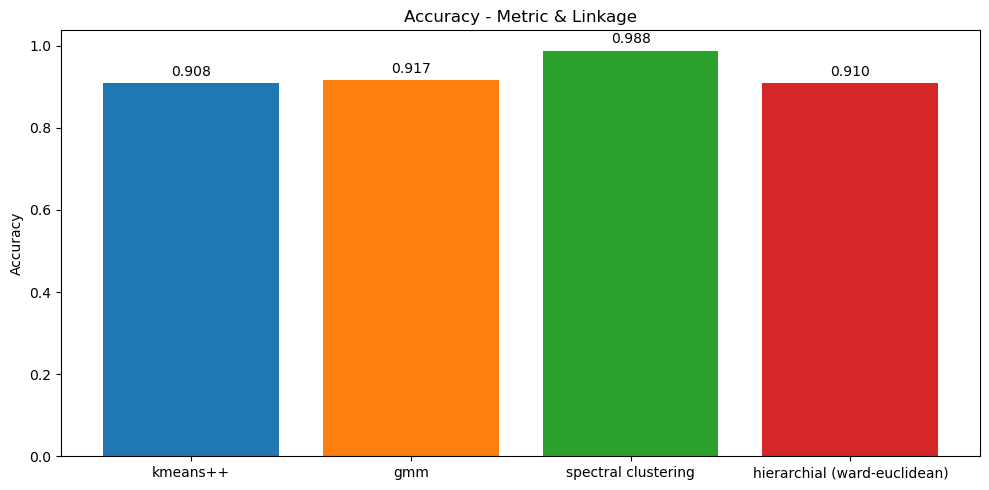

In [11]:
keys = list(accuracy_dict.keys())
vals = list(accuracy_dict.values())

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(keys, vals, color=colors)
ax.bar_label(bars, fmt='%.3f', padding=3)

ax.set_ylabel('Accuracy')
ax.set_title('Accuracy - Metric & Linkage')
plt.tight_layout()
plt.show()

Clearly, spectral clustering performs the best because it has a build in dimensional reduction! Therefore, now let us apply UMAP to all these methods and recompare.

# Dimensional Reduction + Clustering Methods